In [175]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import pickle

from copy import deepcopy

from rashomon.sets import RashomonSet

%matplotlib inline

In [73]:
dir = "../Results/TE/"

setup_id = 1
n_iters = 10
n_per_pol = 10

## Read Rashomon results

In [131]:
method = "rashomon"

rashomon_csv = f"te_sims_{setup_id}_{method}_{n_per_pol}_{n_iters}.csv"
rashomon_raw_df = pd.read_csv(dir + rashomon_csv)
rashomon_raw_df = rashomon_raw_df.drop(["Unnamed: 0"], axis=1)

rashomon_raw_df.head()

NameError: name 'setup_id' is not defined

In [90]:
rashomon_df = rashomon_raw_df.copy()

reg = 1e-1

rashomon_df["loss"] = rashomon_df["MSE"] + reg * rashomon_df["num_pools"]
rashomon_df["min_loss"] = rashomon_df.groupby(["n_per_pol", "sim_num"])["loss"].transform("min")
rashomon_df["max_te_err"] = rashomon_df["max_te_diff"] ** 2


losses = np.array(rashomon_df["loss"])
min_loss = np.min(losses)
max_loss = np.max(losses)
epsilons = (losses - min_loss) / min_loss
max_epsilon = np.max(epsilons)

print(f"Loss range: ({min_loss}, {max_loss}); epsilon = {max_epsilon}")

rashomon_df.head()

Loss range: (1.423419292318626, 1.9999610691220853); epsilon = 0.4050400187174104


,n_per_pol,sim_num,idx,te_idx,MSE_TE,max_te_diff,IOU,MSE,num_pools,loss,min_loss,max_te_err
0,10,0,0,0,2.215119,0.069926,0.714286,0.245833,13,1.545833,1.445833,0.004890
1,10,0,0,1,2.303601,-0.010875,0.714286,0.327443,12,1.527443,1.445833,0.000118
2,10,0,0,2,2.373742,-0.030008,0.714286,0.290773,12,1.490773,1.445833,0.000900
3,10,0,0,3,2.173728,0.028504,0.714286,0.267281,12,1.467281,1.445833,0.000812
4,10,0,0,4,2.281720,0.182620,0.714286,0.302982,12,1.502982,1.445833,0.033350


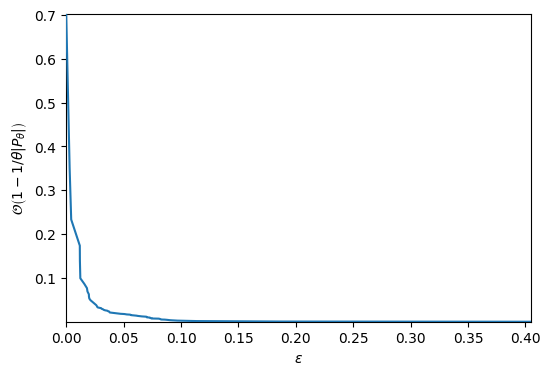

In [91]:
fig, ax = plt.subplots(figsize=(6, 4))

sorted_losses = np.sort(losses)
sorted_epsilons = np.sort(epsilons)
R_set_range = np.arange(0, len(sorted_losses)) + 1
err_bound = 1 / (sorted_losses * R_set_range)

ax.plot(sorted_epsilons, err_bound,
        zorder=3.1)

ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"$\mathcal{O} \left( 1 - 1 / \theta |P_{\theta}| \right)$", rotation=90)

ax.set_xlim(0, np.max(sorted_epsilons))
ax.set_ylim(np.min(err_bound), np.max(err_bound))

plt.show()

In [103]:
print(len(conf_matrices))

752


In [104]:
conf_matrices[0]

[array([[ 9,  0,  1],
        [ 1,  0,  1],
        [ 2,  0, 34]]),
 array([[ 7,  2,  1],
        [ 0,  0,  2],
        [ 1,  0, 35]]),
 array([[ 3,  6,  1],
        [ 0,  0,  2],
        [ 1,  0, 35]]),
 array([[ 8,  1,  1],
        [ 0,  0,  2],
        [ 0,  1, 35]]),
 array([[ 9,  1,  0],
        [ 1,  0,  1],
        [ 2,  5, 29]]),
 array([[ 9,  0,  1],
        [ 1,  0,  1],
        [ 2,  2, 32]]),
 array([[ 9,  0,  1],
        [ 1,  0,  1],
        [ 2,  2, 32]]),
 array([[ 9,  0,  1],
        [ 1,  0,  1],
        [ 2,  6, 28]]),
 array([[ 9,  0,  1],
        [ 0,  1,  1],
        [ 1,  1, 34]]),
 array([[ 9,  0,  1],
        [ 1,  1,  0],
        [ 2,  5, 29]]),
 array([[ 9,  0,  1],
        [ 1,  0,  1],
        [ 2,  2, 32]]),
 array([[ 9,  0,  1],
        [ 1,  0,  1],
        [ 2,  6, 28]])]

In [106]:
eps_threshold = 0.1

rashomon_df["loss_threshold"] = rashomon_df["min_loss"] * (1 + eps_threshold)
rashomon_subset = rashomon_df[rashomon_df["loss"] <= rashomon_df["loss_threshold"]].copy()

subset_dict = rashomon_subset[["sim_num", "idx", "te_idx"]].to_dict(orient="records")

rashomon_subset.head()

,n_per_pol,sim_num,idx,te_idx,MSE_TE,max_te_diff,IOU,MSE,num_pools,loss,min_loss,max_te_err,loss_threshold
0,10,0,0,0,2.215119,0.069926,0.714286,0.245833,13,1.545833,1.445833,0.004890,1.590416
1,10,0,0,1,2.303601,-0.010875,0.714286,0.327443,12,1.527443,1.445833,0.000118,1.590416
2,10,0,0,2,2.373742,-0.030008,0.714286,0.290773,12,1.490773,1.445833,0.000900,1.590416
3,10,0,0,3,2.173728,0.028504,0.714286,0.267281,12,1.467281,1.445833,0.000812,1.590416
4,10,0,0,4,2.281720,0.182620,0.714286,0.302982,12,1.502982,1.445833,0.033350,1.590416


In [108]:
groupby_cols = ["n_per_pol"]

average_cols = ["MSE_TE", "IOU", "max_te_err"]

for col in average_cols:
    mean_col = "mean_" + col    
    rashomon_subset[mean_col] = rashomon_subset.groupby(groupby_cols)[col].transform("mean")

rashomon_subset = rashomon_subset.drop_duplicates(subset=groupby_cols, keep="last")

cols_to_keep = ["n_per_pol", "mean_MSE_TE", "mean_max_te_err", "mean_IOU"]
rashomon_subset = rashomon_subset[cols_to_keep]

rashomon_subset.head()

,n_per_pol,mean_MSE_TE,mean_max_te_err,mean_IOU
6636,10,2.211857,0.00322,0.714286


In [173]:
method = "rashomon"

rashomon_pkl = f"te_sims_{sim_num}_{method}_{n_per_pol}_{n_iters}_conf_mat.pkl"
with open(os.path.join(dir, rashomon_pkl), "rb") as f:
    r_conf_matrices = pickle.load(f)

r_conf_mat_subset = []

for record in subset_dict:
    sim_i = record["sim_num"]
    r_idx = record["idx"]
    te_idx = record["te_idx"]
    conf_mat_i = r_conf_matrices[sim_i][r_idx][te_idx]
    r_conf_mat_subset.append(conf_mat_i)

r_conf_matrices = np.array(r_conf_mat_subset)
# r_conf_mean = np.mean(r_conf_matrices, axis=0)

r_conf_mean = np.sum(r_conf_matrices, axis=0, dtype=np.float64)
r_conf_mean[0, :] = r_conf_mean[0, :] / np.sum(r_conf_mean[0, :])
r_conf_mean[1, :] = r_conf_mean[1, :] / np.sum(r_conf_mean[1, :])
r_conf_mean[2, :] = r_conf_mean[2, :] / np.sum(r_conf_mean[2, :])


print(r_conf_mean)

[[0.82289157 0.08385542 0.09325301]
 [0.19156627 0.10843373 0.7       ]
 [0.03246319 0.0356091  0.93192771]]


In [162]:
np.sum(r_conf_mean, axis=0)

array([ 4059,   970, 14891])

,n_per_pol,sim_num,idx,te_idx,MSE_TE,max_te_diff,IOU,MSE,num_pools,loss,min_loss
0,10,0,0,0,2.215119,0.069926,0.714286,0.245833,13,1.545833,1.445833
1,10,0,0,1,2.303601,-0.010875,0.714286,0.327443,12,1.527443,1.445833
2,10,0,0,2,2.373742,-0.030008,0.714286,0.290773,12,1.490773,1.445833
3,10,0,0,3,2.173728,0.028504,0.714286,0.267281,12,1.467281,1.445833
4,10,0,0,4,2.281720,0.182620,0.714286,0.302982,12,1.502982,1.445833


## Read CF results

In [58]:
method = "cf"

cf_csv = f"te_sims_{setup_id}_{method}_{n_per_pol}_{n_iters}.csv"
cf_raw_df = pd.read_csv(dir + cf_csv)
cf_raw_df = cf_raw_df.drop(["Unnamed: 0"], axis=1)

cf_raw_df.head()

,n_per_pol,sim_num,MSE_TE,max_te_diff,IOU
0,10,0,2.185779,-0.108287,0.000000
1,10,1,2.200817,-0.019324,0.142857
2,10,2,2.097369,-0.126524,0.142857
3,10,3,2.196258,-0.102771,0.000000
4,10,4,2.111067,-0.141831,0.142857


In [110]:
cf_df = cf_raw_df.copy()

cf_df["max_te_err"] = cf_df["max_te_diff"] ** 2

groupby_cols = ["n_per_pol"]

average_cols = ["MSE_TE", "IOU", "max_te_err"]

for col in average_cols:
    mean_col = "mean_" + col    
    cf_df[mean_col] = cf_df.groupby(groupby_cols)[col].transform("mean")

cf_df = cf_df.drop_duplicates(subset=groupby_cols, keep="last")

cols_to_keep = ["n_per_pol", "mean_MSE_TE", "mean_max_te_err", "mean_IOU"]
cf_df = cf_df[cols_to_keep]

cf_df.head()

,n_per_pol,mean_MSE_TE,mean_max_te_err,mean_IOU
9,10,2.172704,0.019951,0.1


In [188]:
method = "cf"

cf_pkl = f"te_sims_{sim_num}_{method}_{n_per_pol}_{n_iters}_conf_mat.pkl"
with open(os.path.join(dir, cf_pkl), "rb") as f:
    cf_conf_matrices = pickle.load(f)

cf_conf_matrices = np.array(cf_conf_matrices)
cf_conf_mean = np.mean(cf_conf_matrices, axis=0)

print(cf_conf_mean)

[[0.9        0.         0.1       ]
 [0.25       0.         0.75      ]
 [0.03055556 0.         0.96944444]]


1. CFs will get about the same MSE because they're still partitioning (might even be better)
2. But because of their weird penalty, they will lose out on coverage as they become more granular
3. CFs optimize for a different thing - error in treatment effect $(\tau - \widehat{\tau})^2$; not overall MSE $(y - \widehat{y})^2$

## Read Lasso results

In [74]:
method = "lasso"

lasso_csv = f"te_sims_{setup_id}_{method}_{n_per_pol}_{n_iters}.csv"
lasso_raw_df = pd.read_csv(dir + lasso_csv)
lasso_raw_df = lasso_raw_df.drop(["Unnamed: 0"], axis=1)

lasso_raw_df.head()

,n_per_pol,sim_num,MSE_TE,max_te_diff,IOU
0,10,0,2.592550,3.686004,0.428571
1,10,1,2.597145,3.666697,0.428571
2,10,2,2.540405,3.673876,0.428571
3,10,3,2.587209,3.639807,0.428571
4,10,4,2.498636,3.604312,0.428571


In [111]:
lasso_df = lasso_raw_df.copy()

lasso_df["max_te_err"] = lasso_df["max_te_diff"] ** 2

groupby_cols = ["n_per_pol"]

average_cols = ["MSE_TE", "IOU", "max_te_err"]

for col in average_cols:
    mean_col = "mean_" + col    
    lasso_df[mean_col] = lasso_df.groupby(groupby_cols)[col].transform("mean")

lasso_df = lasso_df.drop_duplicates(subset=groupby_cols, keep="last")

cols_to_keep = ["n_per_pol", "mean_MSE_TE", "mean_max_te_err", "mean_IOU"]
lasso_df = lasso_df[cols_to_keep]

lasso_df.head()

,n_per_pol,mean_MSE_TE,mean_max_te_err,mean_IOU
9,10,2.55354,13.264821,0.428571


In [138]:
method = "lasso"

lasso_pkl = f"te_sims_{sim_num}_{method}_{n_per_pol}_{n_iters}_conf_mat.pkl"
with open(os.path.join(dir, lasso_pkl), "rb") as f:
    lasso_conf_matrices = pickle.load(f)

lasso_conf_matrices = np.array(lasso_conf_matrices)
lasso_conf_mean = np.mean(lasso_conf_matrices, axis=0)

print(lasso_conf_mean)

[[0.2 0.  0.8]
 [0.  0.  1. ]
 [0.  0.  1. ]]


## Plots

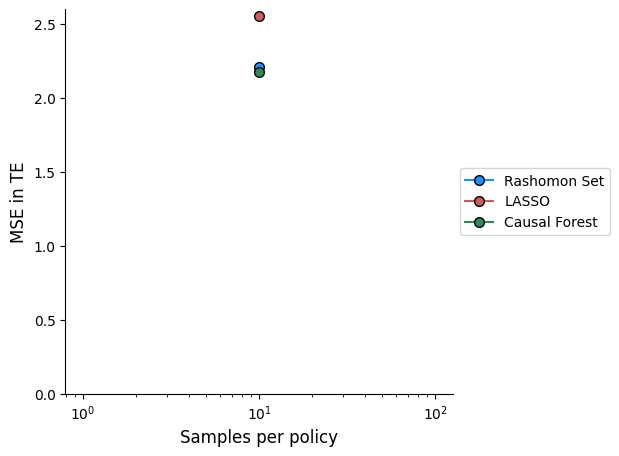

In [117]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.plot(rashomon_subset["n_per_pol"], rashomon_subset["mean_MSE_TE"],
        color="dodgerblue", zorder=1,
        marker="o", markeredgecolor="black", markersize=7,
        label="Rashomon Set")

ax.plot(lasso_df["n_per_pol"], lasso_df["mean_MSE_TE"],
        color="indianred", zorder=3, clip_on=False,
        marker="o", markeredgecolor="black", markersize=7,
        label="LASSO")

ax.plot(cf_df["n_per_pol"], cf_df["mean_MSE_TE"],
        color="seagreen", zorder=3.5, clip_on=False,
        marker="o", markeredgecolor="black", markersize=7,
        label="Causal Forest")

ax.set_xscale("log")
ax.set_xlabel("Samples per policy", fontsize=12)
ax.set_ylim(0, 2.6)
ax.set_ylabel("MSE in TE", fontsize=12)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig(f"../Figures/TE/sim_{setup_id}_MSE_TE.png", dpi=300, bbox_inches="tight")
plt.show()

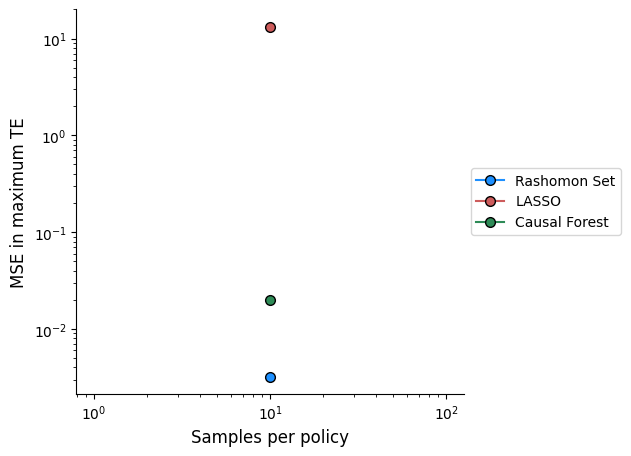

In [119]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.plot(rashomon_subset["n_per_pol"], rashomon_subset["mean_max_te_err"],
        color="dodgerblue", zorder=1,
        marker="o", markeredgecolor="black", markersize=7,
        label="Rashomon Set")

ax.plot(lasso_df["n_per_pol"], lasso_df["mean_max_te_err"],
        color="indianred", zorder=3, clip_on=False,
        marker="o", markeredgecolor="black", markersize=7,
        label="LASSO")

ax.plot(cf_df["n_per_pol"], cf_df["mean_max_te_err"],
        color="seagreen", zorder=3.5, clip_on=False,
        marker="o", markeredgecolor="black", markersize=7,
        label="Causal Forest")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Samples per policy", fontsize=12)
# ax.set_ylim(0, 2.6)
ax.set_ylabel("MSE in maximum TE", fontsize=12)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig(f"../Figures/TE/sim_{setup_id}_MSE_max_TE.png", dpi=300, bbox_inches="tight")
plt.show()

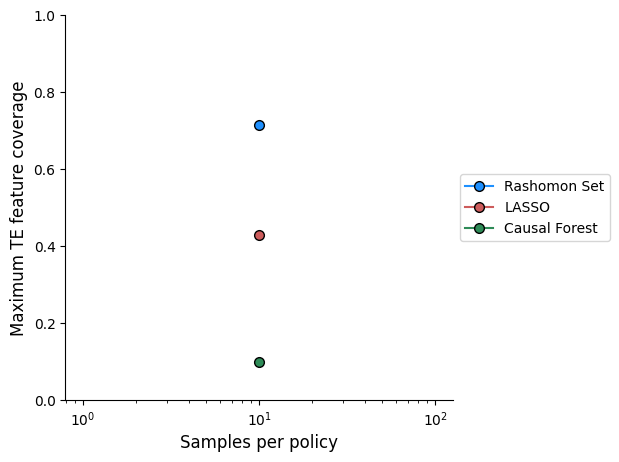

In [120]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.plot(rashomon_subset["n_per_pol"], rashomon_subset["mean_IOU"],
        color="dodgerblue", zorder=1,
        marker="o", markeredgecolor="black", markersize=7,
        label="Rashomon Set")

ax.plot(lasso_df["n_per_pol"], lasso_df["mean_IOU"],
        color="indianred", zorder=3, clip_on=False,
        marker="o", markeredgecolor="black", markersize=7,
        label="LASSO")

ax.plot(cf_df["n_per_pol"], cf_df["mean_IOU"],
        color="seagreen", zorder=3.5, clip_on=False,
        marker="o", markeredgecolor="black", markersize=7,
        label="Causal Forest")

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Samples per policy", fontsize=12)
ax.set_ylim(0, 1)
ax.set_ylabel("Maximum TE feature coverage", fontsize=12)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig(f"../Figures/TE/sim_{setup_id}_IOU.png", dpi=300, bbox_inches="tight")
plt.show()

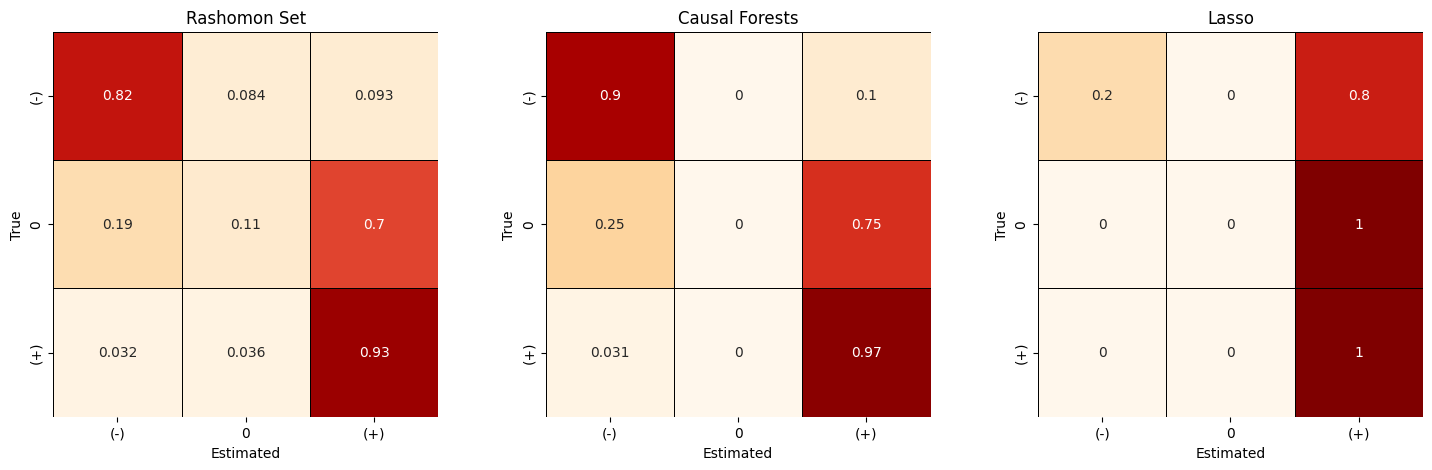

In [190]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

sns.heatmap(
    r_conf_mean,
    cmap="OrRd",
    linewidths=0.5,
    linecolor="black",
    annot=True,
    square=True,
    vmin=0,
    vmax=1,
    ax=ax[0],
    cbar=False
)
ax[0].set_title("Rashomon Set")

sns.heatmap(
    cf_conf_mean,
    cmap="OrRd",
    linewidths=0.5,
    linecolor="black",
    annot=True,
    square=True,
    vmin=0,
    vmax=1,
    ax=ax[1],
    cbar=False
)
ax[1].set_title("Causal Forests")

sns.heatmap(
    lasso_conf_mean,
    cmap="OrRd",
    linewidths=0.5,
    linecolor="black",
    annot=True,
    square=True,
    vmin=0,
    vmax=1,
    ax=ax[2],
    cbar=False
)
ax[2].set_title("Lasso")


for i in range(3):
    ax[i].set_xlabel("Estimated")
    ax[i].set_ylabel("True")
    
    ax[i].set_xticks(np.array([0, 1, 2])+0.5, ["(-)", "0", "(+)"])
    ax[i].set_yticks(np.array([0, 1, 2])+0.5, ["(-)", "0", "(+)"])


# fname = f"../Figures/TE/sim_{setup_id}_confusion_matrix.png"
# plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()